#### Detect FRC/supercluster enriched/depleted KOs

In [1]:
import pandas as pd
gcn_df = pd.read_csv('../data/gcn2008.tsv', sep='\t', index_col=0)
cluster_df = pd.read_csv('../result/GCN_fix_tree/leaves_cluster.tsv', sep='\t', index_col=0, header=0)
cluster_df.fillna('NA', inplace=True)
outdir = '../result/GCN_fix_tree'
interested_cluster = 'S1_C8'


In [2]:
interested_species = cluster_df.index[
    (cluster_df['cluster'] == interested_cluster) | 
    (cluster_df['supercluster'] == interested_cluster)
].tolist()

interested_species_count = len(interested_species)
print(f"{interested_cluster} contains interested_species_count species.")


S1_C8 contains interested_species_count species.


In [3]:
# Count the total number of species
total_species_count = gcn_df.shape[0]

# Calculate KO occurrence statistics for these species in gcn2008.tsv
column_names = {
    'KO': 'KO',
    'interested_present': f'{interested_cluster} Present', 
    'interested_occurrence': f'{interested_cluster} Occurrence', 
    'all_present': 'All Present', 
    'all_occurrence': 'All Occurrence'
}

kos_df1 = pd.DataFrame(columns=list(column_names.values()))

for ko in gcn_df.columns:
    # Calculate presence rate and occurrence rate in the cluster of interest
    ko_interested_present = (gcn_df.loc[interested_species, ko] > 0).sum() / interested_species_count
    ko_interested_counts = gcn_df.loc[interested_species, ko].sum()
    ko_interested_occurrence = ko_interested_counts / interested_species_count
    
    # Calculate presence rate and occurrence rate across all species
    ko_all_present = (gcn_df[ko] > 0).sum() / total_species_count
    ko_all_occurrence = gcn_df[ko].sum() / total_species_count
    
    # Create a new row
    new_row = {
        column_names['KO']: ko,
        column_names['interested_present']: ko_interested_present,
        column_names['interested_occurrence']: ko_interested_occurrence,
        column_names['all_present']: ko_all_present,
        column_names['all_occurrence']: ko_all_occurrence
    }
    
    # Add to DataFrame
    kos_df1 = pd.concat([kos_df1, pd.DataFrame([new_row])], ignore_index=True)

# Sort by occurrence rate in the cluster of interest (descending)
kos_df1 = kos_df1.sort_values(by=column_names['interested_occurrence'], ascending=False)

# Output to file
output_file1 = f'{outdir}/{interested_cluster}.kos_summary.tsv'
kos_df1.to_csv(output_file1, sep='\t', index=False)
print(f"KO occurrence statistics saved to: {output_file1}")


KO occurrence statistics saved to: ../result/GCN_fix_tree/S1_C8.kos_summary.tsv


In [4]:
# Fisher's exact test analysis
from scipy.stats import fisher_exact
from statsmodels.stats.multitest import fdrcorrection

# Create result DataFrame
column_names2 = {
    'KO': 'KO',
    'interested_present': f'{interested_cluster} Present',
    'interested_absent': f'{interested_cluster} Absent',
    'non_interested_present': f'Non {interested_cluster} Present',
    'non_interested_absent': f'Non {interested_cluster} Absent',
    'odds_ratio': 'Odds Ratio',
    'pvalue': 'P-value',
    'adjusted_pvalue': 'Adjusted P-value'
}

kos_df2 = pd.DataFrame(columns=list(column_names2.values()))
pvalues = []

for ko in gcn_df.columns:
    # Count species in the cluster of interest with and without this KO
    ko_interested_present = (gcn_df.loc[interested_species, ko] > 0).sum()
    ko_interested_absent = interested_species_count - ko_interested_present
    
    # Count species not in the cluster of interest with and without this KO
    ko_non_interested_present = (gcn_df.loc[~gcn_df.index.isin(interested_species), ko] > 0).sum()
    ko_non_interested_absent = total_species_count - interested_species_count - ko_non_interested_present
    
    # Perform Fisher's exact test
    contingency_table = [
        [ko_interested_present, ko_interested_absent], 
        [ko_non_interested_present, ko_non_interested_absent]
    ]
    oddsratio, pvalue = fisher_exact(contingency_table, alternative='two-sided')
    pvalues.append(pvalue)
    
    # Create a new row
    new_row = {
        column_names2['KO']: ko,
        column_names2['interested_present']: ko_interested_present,
        column_names2['interested_absent']: ko_interested_absent,
        column_names2['non_interested_present']: ko_non_interested_present,
        column_names2['non_interested_absent']: ko_non_interested_absent,
        column_names2['odds_ratio']: oddsratio,
        column_names2['pvalue']: pvalue
    }
    
    # Add to DataFrame
    kos_df2 = pd.concat([kos_df2, pd.DataFrame([new_row])], ignore_index=True)

# Apply FDR correction to p-values
_, adjusted_pvalues = fdrcorrection(pvalues, alpha=0.05, method='indep')
kos_df2[column_names2['adjusted_pvalue']] = adjusted_pvalues

# Sort by adjusted p-value (ascending)
kos_df2 = kos_df2.sort_values(by=column_names2['adjusted_pvalue'], ascending=True)

# Output to file

output_file2 = f'{outdir}/{interested_cluster}.kos_fisher.tsv'
kos_df2.to_csv(output_file2, sep='\t', index=False)
print(f"Fisher's exact test results saved to: {output_file2}")


Fisher's exact test results saved to: ../result/GCN_fix_tree/S1_C8.kos_fisher.tsv


In [5]:
# Identify significantly enriched and depleted KOs
enriched_kos = kos_df2[(kos_df2[column_names2['adjusted_pvalue']] < 0.05) & 
                       (kos_df2[column_names2['odds_ratio']] > 2)]

depleted_kos = kos_df2[(kos_df2[column_names2['adjusted_pvalue']] < 0.05) & 
                       (kos_df2[column_names2['odds_ratio']] < 0.5)]  # 0.5 = 1/2

# Print comprehensive statistics summary
print(f"\nAnalysis Summary:")
print(f"After statistical filtering (adjusted p-value < 0.05, odds ratio > 2 or < 0.5):")
print(f"- Found {len(enriched_kos)} significantly enriched KOs (odds ratio > 2)")
print(f"- Found {len(depleted_kos)} significantly depleted KOs (odds ratio < 0.5)")
print(f"- Total {len(enriched_kos) + len(depleted_kos)} differentially abundant KOs")


Analysis Summary:
After statistical filtering (adjusted p-value < 0.05, odds ratio > 2 or < 0.5):
- Found 281 significantly enriched KOs (odds ratio > 2)
- Found 1388 significantly depleted KOs (odds ratio < 0.5)
- Total 1669 differentially abundant KOs


In [6]:
import pandas as pd

# Species list
species_list = [
    "s__Akkermansia_muciniphila",
    "s__Akkermansia_glycaniphila",
    "s__Adlercreutzia_equolifaciens",
    "s__Eggerthella_lenta",
    "s__Treponema_denticola",
    "s__Bilophila_wadsworthia",
    "s__Fusobacterium_varium",
    "s__Slackia_exigua"
]

# 1. Find KOs that are non-zero in 50%-75% of species
valid_species = [s for s in species_list if s in gcn_df.index]
species_df = gcn_df.loc[valid_species]

# Calculate 50% and 75% thresholds
lower_threshold = int(len(valid_species) * 0.50 + 0.5)  # 50%, round up
upper_threshold = int(len(valid_species) * 0.75)  # 75%, round down

print(f"Filtering KOs that are non-zero in {lower_threshold}-{upper_threshold} species (50%-75% of total {len(valid_species)} species)")

# Find KOs that are non-zero in 50%-75% of species
non_zero_counts = (species_df > 0).sum(axis=0)
medium_kos = species_df.columns[(non_zero_counts >= lower_threshold) & (non_zero_counts <= upper_threshold)].tolist()

print(f"Number of KOs that are non-zero in {lower_threshold}-{upper_threshold} species (50%-75%): {len(medium_kos)}")

# 2. Check if these KOs are in enriched_kos
enriched_ko_list = enriched_kos[column_names2['KO']].tolist()
medium_kos_in_enriched = [ko for ko in medium_kos if ko in enriched_ko_list]

print(f"\nNumber of medium-prevalence KOs found in enriched_kos: {len(medium_kos_in_enriched)}")

# 3. Read KO name file
ko_name_file = "../result/GCN_fix_tree/ko_name"
ko_name_df = pd.read_csv(ko_name_file, sep='\t', header=None, names=['KO_ID', 'KO_Name'])

# 4. Get detailed information for medium-prevalence and enriched KOs
enriched_medium_ko_info = []

for ko in medium_kos_in_enriched:
    # Get the number of species where this KO is non-zero
    non_zero_count = (species_df[ko] > 0).sum()
    
    # Get adjusted p-value and effect size for this KO from enriched_kos
    ko_row = enriched_kos[enriched_kos[column_names2['KO']] == ko]
    adj_pval = ko_row[column_names2['adjusted_pvalue']].values[0] if not ko_row.empty else None
    odds_ratio = ko_row[column_names2['odds_ratio']].values[0] if not ko_row.empty else None
    
    # Get KO name
    ko_name_row = ko_name_df[ko_name_df['KO_ID'] == ko]
    ko_name = ko_name_row['KO_Name'].values[0] if not ko_name_row.empty else "Unknown name"
    
    # Get species where this KO is present
    present_in_species = [species for species in valid_species if species_df.loc[species, ko] > 0]
    
    enriched_medium_ko_info.append({
        'KO_ID': ko,
        'KO_Name': ko_name,
        'Non_Zero_Species_Count': non_zero_count,
        'Non_Zero_Species_Percentage': non_zero_count / len(valid_species) * 100,
        'Present_In_Species': ', '.join(present_in_species),
        'Adjusted_P_Value': adj_pval,
        'Odds_Ratio': odds_ratio
    })

# 5. Create DataFrame with all information
result_df = pd.DataFrame(enriched_medium_ko_info)

# 6. Sort by adjusted p-value
if not result_df.empty:
    result_df = result_df.sort_values(by='Adjusted_P_Value')

# 7. Display results
if not result_df.empty:
    print("\nMedium-prevalence and enriched KOs with names (sorted by adjusted p-value):")
    for i, row in result_df.iterrows():
        print(f"{row['KO_ID']}\t{row['KO_Name']}\tPresent in {row['Non_Zero_Species_Count']} species ({row['Non_Zero_Species_Percentage']:.1f}%)\tAdjusted p-value: {row['Adjusted_P_Value']:.4e}\tEffect size: {row['Odds_Ratio']:.2f}")
    
    # Save results to file
    # result_df.to_csv('medium_prevalence_enriched_ko_with_names.tsv', sep='\t', index=False)
    
    # Statistical analysis of functional categories
    print("\nFunctional category statistics:")
    
    def categorize_ko(ko_name):
        ko_name = ko_name.lower()
        if any(term in ko_name for term in ['transferase', 'kinase', 'synthase']):
            return 'Enzyme'
        elif any(term in ko_name for term in ['transport', 'permease', 'porter']):
            return 'Transport'
        elif any(term in ko_name for term in ['regulator', 'repressor', 'activator']):
            return 'Regulation'
        elif any(term in ko_name for term in ['ribosomal', 'rna', 'translation']):
            return 'Translation'
        else:
            return 'Other'
    
    result_df['Category'] = result_df['KO_Name'].apply(categorize_ko)
    category_counts = result_df['Category'].value_counts()
    
    for category, count in category_counts.items():
        print(f"{category}: {count} ({count/len(result_df):.1%})")
    
    # Analyze distribution patterns of KOs
    print("\nSpecies containing medium-prevalence KOs:")
    species_ko_counts = {}
    for species in valid_species:
        species_ko_counts[species] = sum(1 for ko in medium_kos_in_enriched if species_df.loc[species, ko] > 0)
    
    # Sort species by KO count
    sorted_species = sorted(species_ko_counts.items(), key=lambda x: x[1], reverse=True)
    for species, count in sorted_species:
        print(f"{species}: {count} KOs ({count/len(medium_kos_in_enriched):.1%})")
    
    # Create co-occurrence matrix: analyze which KOs frequently appear together
    if len(medium_kos_in_enriched) <= 30:  # If KO count is manageable, calculate co-occurrence
        print("\nKO co-occurrence patterns:")
        for i, ko1 in enumerate(medium_kos_in_enriched):
            ko1_species = set(species for species in valid_species if species_df.loc[species, ko1] > 0)
            for ko2 in medium_kos_in_enriched[i+1:]:
                ko2_species = set(species for species in valid_species if species_df.loc[species, ko2] > 0)
                common_species = ko1_species.intersection(ko2_species)
                if len(common_species) >= lower_threshold:  # If two KOs co-occur in at least 50% threshold species
                    print(f"{ko1} and {ko2} co-occur in {len(common_species)} species")
else:
    print("No KOs found that are both non-zero in 50%-75% of species and present in enriched_kos")

Filtering KOs that are non-zero in 4-6 species (50%-75% of total 8 species)
Number of KOs that are non-zero in 4-6 species (50%-75%): 435

Number of medium-prevalence KOs found in enriched_kos: 79

Medium-prevalence and enriched KOs with names (sorted by adjusted p-value):
K05919	dfx; superoxide reductase [EC:1.15.1.2]	Present in 6 species (75.0%)	Adjusted p-value: 2.8102e-21	Effect size: 21.01
K18707	mtaB; threonylcarbamoyladenosine tRNA methylthiotransferase MtaB [EC:2.8.4.5]	Present in 6 species (75.0%)	Adjusted p-value: 2.1898e-10	Effect size: 11.20
K06898	larB; pyridinium-3,5-biscarboxylic acid mononucleotide synthase [EC:2.5.1.143]	Present in 6 species (75.0%)	Adjusted p-value: 4.3089e-09	Effect size: 6.76
K09949	lpxI; UDP-2,3-diacylglucosamine hydrolase [EC:3.6.1.54]	Present in 4 species (50.0%)	Adjusted p-value: 4.5995e-09	Effect size: 8.04
K05515	mrdA; penicillin-binding protein 2 [EC:3.4.16.4]	Present in 6 species (75.0%)	Adjusted p-value: 2.0529e-08	Effect size: 8.95
K08353	


Created subset table shape: (8, 79) (rows: number of species, columns: number of KOs)

Preview of first 5 columns in subset table:
                                K05919  K18707  K06898  K09949  K05515
s__Akkermansia_muciniphila           0       0       1       1       0
s__Akkermansia_glycaniphila          0       0       1       1       0
s__Adlercreutzia_equolifaciens       1       1       1       0       1
s__Eggerthella_lenta                 1       1       1       0       1
s__Treponema_denticola               1       1       0       0       1
s__Bilophila_wadsworthia             2       1       1       1       1
s__Fusobacterium_varium              1       1       1       1       1
s__Slackia_exigua                    1       1       0       0       1


<Figure size 2200x1000 with 0 Axes>

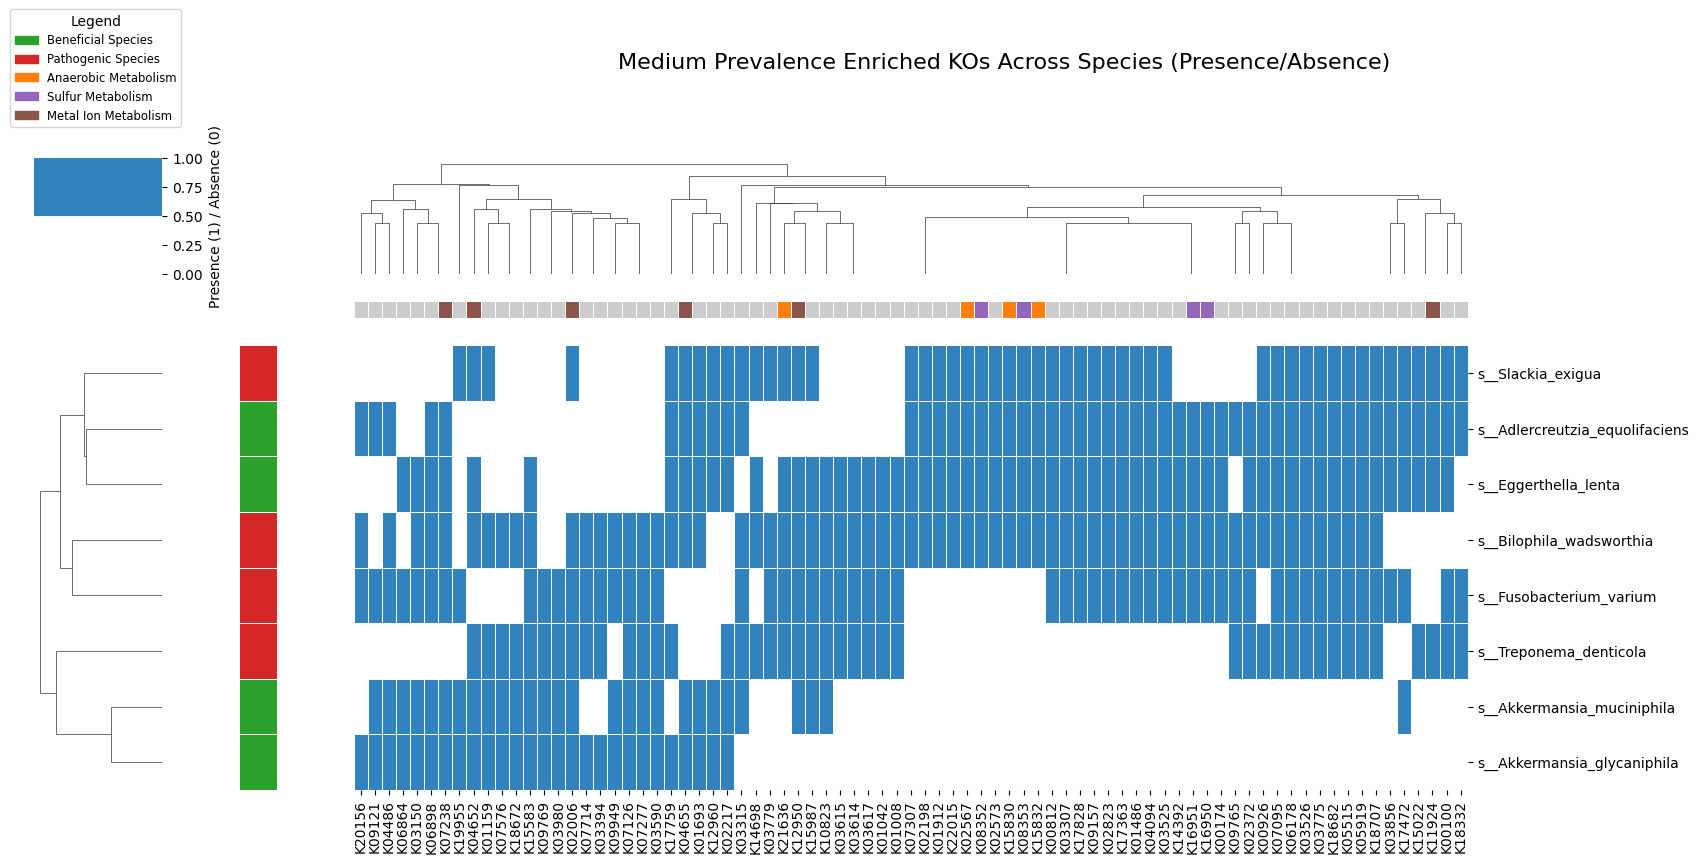

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from scipy.spatial import distance

# Read previously saved data
# result_df = pd.read_csv('medium_prevalence_enriched_ko_with_names.tsv', sep='\t')

# Distinguish beneficial and pathogenic bacteria
beneficial_species = [
    "s__Akkermansia_muciniphila", 
    "s__Akkermansia_glycaniphila", 
    "s__Adlercreutzia_equolifaciens", 
    "s__Eggerthella_lenta"
]

pathogenic_species = [
    "s__Treponema_denticola",
    "s__Bilophila_wadsworthia",
    "s__Fusobacterium_varium",
    "s__Slackia_exigua"
]

# Add beneficial and pathogenic bacteria columns for each KO
result_df['Present_In_Beneficial'] = result_df['Present_In_Species'].apply(
    lambda x: ', '.join([s for s in x.split(', ') if s in beneficial_species]) 
    if isinstance(x, str) else ''
)

result_df['Present_In_Pathogenic'] = result_df['Present_In_Species'].apply(
    lambda x: ', '.join([s for s in x.split(', ') if s in pathogenic_species])
    if isinstance(x, str) else ''
)

# Calculate presence count and percentage for each KO in beneficial and pathogenic bacteria
result_df['Beneficial_Count'] = result_df['Present_In_Beneficial'].apply(
    lambda x: len(x.split(', ')) if x else 0
)
result_df['Pathogenic_Count'] = result_df['Present_In_Pathogenic'].apply(
    lambda x: len(x.split(', ')) if x else 0
)

result_df['Beneficial_Percentage'] = result_df['Beneficial_Count'] / len(beneficial_species) * 100
result_df['Pathogenic_Percentage'] = result_df['Pathogenic_Count'] / len(pathogenic_species) * 100

# Save updated results
#result_df.to_csv('medium_prevalence_enriched_ko_with_species_types.tsv', sep='\t', index=False)

# List of specific functional KOs
anaerobic_metabolism_kos = [ 'K02567', 'K15830', 'K15832', 'K21636']
sulfur_metabolism_kos = ['K08352', 'K08353', 'K16950', 'K16951']
metal_ion_metabolism_kos = ['K12950', 'K11924', 'K02006', 'K07238', 'K04652', 'K04655']

# Check if these specific KOs are in our medium-prevalence KOs
found_anaerobic_kos = [ko for ko in anaerobic_metabolism_kos if ko in result_df['KO_ID'].values]
found_sulfur_kos = [ko for ko in sulfur_metabolism_kos if ko in result_df['KO_ID'].values]
found_metal_kos = [ko for ko in metal_ion_metabolism_kos if ko in result_df['KO_ID'].values]

# 1. Create new table: containing only medium-prevalence enriched KOs and specified species
# Assume species_df and medium_kos_in_enriched variables already exist
subset_df = species_df[result_df['KO_ID'].tolist()]

# 2. Print table information
print(f"\nCreated subset table shape: {subset_df.shape} (rows: number of species, columns: number of KOs)")
print("\nPreview of first 5 columns in subset table:")
print(subset_df.iloc[:, :5])

# 3. For better visualization, create table with KO names
ko_names = {}
for i, row in result_df.iterrows():
    ko = row['KO_ID']
    name = row['KO_Name']
    # Truncate overly long names
    if len(name) > 30:
        name = name[:27] + "..."
    
    # Add markers for specific functional KOs
    if ko in anaerobic_metabolism_kos:
        name = "[A] " + name  # Anaerobic metabolism
    if ko in sulfur_metabolism_kos:
        name = "[S] " + name  # Sulfur metabolism
    if ko in metal_ion_metabolism_kos:
        name = "[M] " + name  # Metal ion metabolism
    
    ko_names[ko] = f"{ko}: {name}"

# Replace column names with KO names
subset_df_with_names = subset_df.copy()
subset_df_with_names.columns = [ko_names.get(ko, ko) for ko in subset_df.columns]

# 4. Save subset table to file
#subset_df.to_csv('medium_prevalence_ko_species_matrix.csv')

# 5. Prepare heatmap data - replace values greater than 1 with 1 (binarization)
data_for_heatmap = subset_df.copy()
data_for_heatmap = (data_for_heatmap > 0).astype(int)

# 6. Calculate clustering - use binarized data for clustering
row_linkage = hierarchy.linkage(
    distance.pdist(data_for_heatmap),
    method='average'
)

col_linkage = hierarchy.linkage(
    distance.pdist(data_for_heatmap.T),
    method='average'
)

# 7. Draw heatmap
# Increase figure size to make room for legend
plt.figure(figsize=(22, 10))

# Set color mapping - for binary data, use simple dual color mapping
cmap = sns.color_palette(["white", "#3182bd"])  # White (0) to blue (1)

# Label species (beneficial/pathogenic bacteria)
row_colors = []
for species in subset_df.index:
    if species in beneficial_species:
        row_colors.append("#2ca02c")  # Green for beneficial bacteria
    elif species in pathogenic_species:
        row_colors.append("#d62728")  # Red for pathogenic bacteria
    else:
        row_colors.append("#cccccc")  # Gray for others

# Label specific functional KOs
col_colors = []
for ko in subset_df.columns:
    if ko in anaerobic_metabolism_kos:
        col_colors.append("#ff7f0e")  # Orange for anaerobic metabolism
    elif ko in sulfur_metabolism_kos:
        col_colors.append("#9467bd")  # Purple for sulfur metabolism
    elif ko in metal_ion_metabolism_kos:
        col_colors.append("#8c564b")  # Brown for metal ion metabolism
    else:
        col_colors.append("#cccccc")  # Gray for others

# Create heatmap with larger figure size and adjust right margin
g = sns.clustermap(
    data_for_heatmap,
    row_linkage=row_linkage,
    col_linkage=col_linkage,
    cmap=cmap,
    linewidths=0.5,
    xticklabels=True,  # Too many KOs, don't show labels
    yticklabels=True,
    figsize=(20, 8),  # Increase width to leave space for legend
    cbar_kws={"label": "Presence (1) / Absence (0)", "shrink": 0.3},  # Further shrink color bar
    dendrogram_ratio=(0.1, 0.2),
    row_colors=row_colors,
    col_colors=col_colors
)

# Adjust color bar position, move to blank area on the right side of heatmap
cbar_ax = g.ax_heatmap.figure.axes[-1]
# Change color bar position [left, bottom, width, height]
cbar_ax.set_position([0, 0.8, 0.1, 0.1])

# Add legend, place in blank area on the right side outside the heatmap
# Use fig.legend instead of creating separate axes to avoid occlusion
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color="#2ca02c", label="Beneficial Species"),
    plt.Rectangle((0,0), 1, 1, color="#d62728", label="Pathogenic Species"),
    plt.Rectangle((0,0), 1, 1, color="#ff7f0e", label="Anaerobic Metabolism"),
    plt.Rectangle((0,0), 1, 1, color="#9467bd", label="Sulfur Metabolism"),
    plt.Rectangle((0,0), 1, 1, color="#8c564b", label="Metal Ion Metabolism")
]

# Add legend to figure instead of heatmap to avoid occlusion
legend = g.fig.legend(
    handles=legend_elements,
    loc='center left',  # Place at center left of figure right side
    bbox_to_anchor=(0, 1),  # Adjust legend position (x, y)
    frameon=True,
    fontsize='small',
    title="Legend"
)

# Adjust Y-axis label font size
plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10)

# Set title
plt.suptitle("Medium Prevalence Enriched KOs Across Species (Presence/Absence)", fontsize=16, y=1.02)

# Fine-tune overall layout to ensure all elements are visible
g.fig.tight_layout(rect=[0, 0, 0.85, 0.95])  # [left, bottom, right, top] adjust heatmap area range

# Save image
#plt.savefig("medium_prevalence_ko_binary_heatmap_annotated.png", bbox_inches='tight', dpi=300)
#plt.savefig("medium_prevalence_ko_binary_heatmap_annotated.pdf", bbox_inches='tight')

# Display image
plt.show()